In [1]:
from skimage.measure import find_contours
from skimage.feature import corner_harris, corner_peaks, canny 
from skimage.draw import polygon, circle_perimeter, line, disk
from skimage.filters.thresholding import threshold_otsu, threshold_local
from skimage.filters import median
from skimage.transform.hough_transform import hough_circle, hough_circle_peaks
from skimage.color import rgb2gray
import skimage.io as io
import numpy as np
import cv2
import matplotlib.pyplot as plt
import Preproccesing_Custom_Functions as pcf
import csv


In [2]:
def Get_Contour_Area(Contour):

    
    #Extract the corners of the current contour in the loop
    Top_Left = sorted(Contour, key= lambda x: x[0]+x[1])[0] # --> Min(x+y) --> Point with smallest x and smallest y is top left corner
    Top_Right = sorted(Contour, key= lambda x: x[0]-x[1])[-1] # --> Max(x-y) --> Point with largest x and smallest y is top right corner
    Bottom_Left = sorted(Contour, key= lambda x: x[0]-x[1])[0] # --> Min(x-y) --> Point with smallest x and largest y is bottom left corner
    Bottom_Right = sorted(Contour, key= lambda x: x[0]+x[1])[-1] # --> Max(x+y) --> Point with largest x and largest y is bottom right corner

    Length = abs(Top_Left[0] - Top_Right[0])
    Width = abs(Top_Right[1] - Bottom_Right[1])
    
    Contour_Area = Length*Width
    
    return Contour_Area
    

In [212]:
# Load the image

# sample_image_rgb = io.imread("Bubble_sheet/2/Photo 2022-01-06 15.25.10.jpg")
# sample_image_rgb = io.imread("Bubble_sheet/1/ab68fdc7-c490-496e-91c7-96e2dd5e0655.jpg")
# sample_image_rgb = io.imread("Bubble_sheet/1\d5c4bbd0-6e17-435b-b673-55b2e1401d4a.jpg")
# sample_image_rgb = io.imread("Bubble_sheet/2/ec323566-fcac-403a-8882-87812ca231d2.jpg")
# sample_image_rgb = io.imread("Bubble_sheet/4/IMG_2039.jpg")
# sample_image_rgb = io.imread("Bubble_sheet/4\ebb35754-124c-4e35-8ba6-8c6056823e3a.jpg")
sample_image_rgb = io.imread("Bubble_sheet/2\9ac461ac-628b-4fe4-8abb-fd406421dedf.jpg")
# sample_image_rgb = io.imread("Bubble_sheet/2\IMG_6225.JPG")
sample_image_gray = rgb2gray(sample_image_rgb)
# thresh = threshold_local(sample_image_gray, block_size=101,offset=0.09, method='gaussian')
# sample_image_gray = sample_image_gray > thresh
# sample_image_gray=pcf.Apply_Preprocessing(sample_image_rgb,blocksize=21,method="median")
# Find the contours
threshold_rel= ((sample_image_gray.max()+sample_image_gray.min())/2)
Contours=find_contours(sample_image_gray,threshold_rel)

# Sort the contours by area
Contours = sorted(Contours, key=Get_Contour_Area, reverse=True)
Paper_Contour= Contours[0] # The largest contour is the paper contour, the second largest contour is the bubble contour
Inner_Contour= Contours[1]
Name_Contour= Contours[2]


while Get_Contour_Area(Inner_Contour) < 0.4 * sample_image_rgb.shape[0] * sample_image_rgb.shape[1]:
    Contours=find_contours(sample_image_gray,threshold_rel)
    threshold_rel*=1.1
    Inner_Contour = sorted(Contours, key=Get_Contour_Area, reverse=True)[1]
    



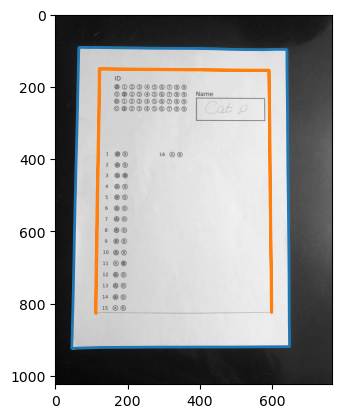

In [213]:
# Display the image and plot the largest 2 contours found
fig, ax = plt.subplots()
ax.imshow(sample_image_gray, cmap=plt.cm.gray)

for i in range(2):
      ax.plot(Contours[i][:, 1], Contours[i][:, 0], linewidth=2)

ax.axis('image')
plt.show()


In [214]:
# Extract the corners of the paper contour
Inner_Contour = np.flip(Inner_Contour, axis=1)
Top_Left = sorted(Inner_Contour, key= lambda x: x[0]+x[1])[0]
Top_Right = sorted(Inner_Contour, key= lambda x: x[0]-x[1])[-1]
Bottom_Left = sorted(Inner_Contour, key= lambda x: x[0]-x[1])[0]
Bottom_Right = sorted(Inner_Contour, key= lambda x: x[0]+x[1])[-1]

Corners=np.array([Top_Left,Top_Right,Bottom_Left,Bottom_Right])

(-0.5, 1049.5, 1484.5, -0.5)

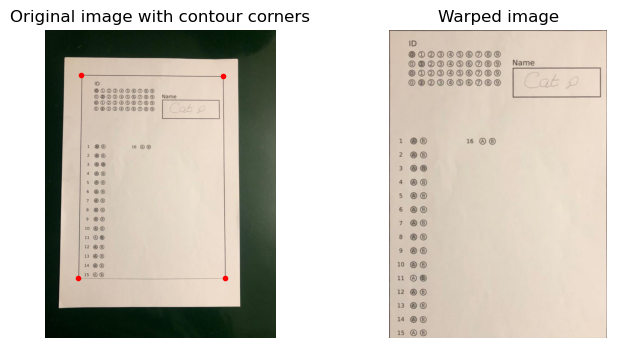

In [215]:
# Using the 4 corners of the contour, warp the image to a rectangle
size_multiplier = 5
width,height = 210*size_multiplier, 297*size_multiplier # A4 paper aspect ratio 210mm x 297mm

img= sample_image_rgb


pts1 = np.float32([Corners[0], Corners[1], Corners[2], Corners[3]]) # The 4 corners of the contour
pts2= np.float32([[0,0],[width,0],[0,height],[width,height]]) # The corners of the final image
matrix = cv2.getPerspectiveTransform(pts1,pts2) # The transformation matrix
result = cv2.warpPerspective(img,matrix,(width,height)) # The warped image
# Rotate the image 90 degrees
io.imsave("IMG_2045_warped.jpg", result)

fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(8, 4))
ax.imshow(img)
ax.plot(Corners[:, 0], Corners[:, 1], 'r.')
ax.set_title('Original image with contour corners')
ax.axis('off')
ax2.imshow(result)
ax2.set_title('Warped image')
ax2.axis('off')


C:\Users\Karim Negm\AppData\Local\Temp\ipykernel_5592\1309448075.py:12: UserWarning: Warped_Thresholded.jpg is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave("Warped_Thresholded.jpg", binary_local)


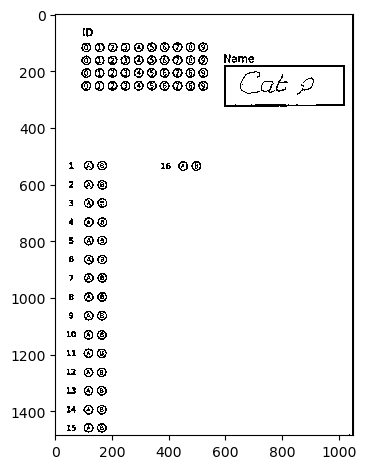

In [216]:
# Apply a local threshold to the warped image
result_gray = io.imread("IMG_2045_Warped.jpg", as_gray=True)
result_gray = result_gray*255

# local_threshold = threshold_local(result_gray, 11, offset=12, method='gaussian', param=8)
local_threshold = threshold_local(result_gray, 21, offset=12, method='median')
binary_local = result_gray > local_threshold
binary_local = median(binary_local)
binary_local = median(binary_local)
binary_local = median(binary_local)
io.imshow(binary_local)
io.imsave("Warped_Thresholded.jpg", binary_local)


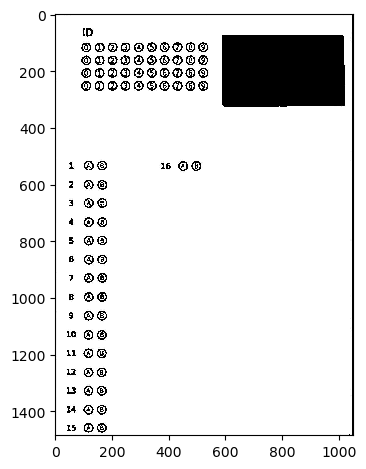

In [217]:
# Before we use hough to detect the circles, we will extract and mask out the name to prevent it from being detected as a circle
sampleimg = io.imread("Warped_Thresholded.jpg", as_gray=True) 

# The name is the largest contour in the already cropped image
Name_Contour= pcf.Get_Nth_Largest_Contour(sampleimg, 1)

# # Plot the name contour
# fig, ax = plt.subplots()
# ax.imshow(sampleimg, cmap=plt.cm.gray)
# ax.plot(Name_Contour[:, 1], Name_Contour[:, 0], linewidth=2)

# Mask out the name contour
mask = np.ones_like(sampleimg)
Name_Contour[:,[0, 1]] = Name_Contour[:,[1, 0]]
cv2.drawContours(mask, [Name_Contour.astype(np.int32)+[0,-100]],0,0,-1)
cv2.drawContours(mask, [Name_Contour.astype(np.int32)],0,0,-1)

masked_image = sampleimg*mask
io.imshow(masked_image)



C:\Users\Karim Negm\AppData\Local\Temp\ipykernel_5592\3021879715.py:3: UserWarning: test.jpg is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave("test.jpg",Edges)


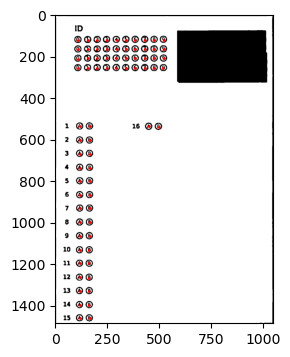

In [218]:
Original = masked_image
Edges = canny(Original, sigma=1, low_threshold=60, high_threshold=90)
io.imsave("test.jpg",Edges)
# Find the circles of the bubble sheet using hough circles
radii = np.arange(17, 20, 1)
circles = hough_circle(Edges, radii)
accum, cx, cy, rad=hough_circle_peaks(circles, radii, min_xdistance= 35, min_ydistance=35, threshold=0.4)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
ax.imshow(Original, cmap=plt.cm.gray)
ax.plot(cx, cy, '.r', markersize=2)


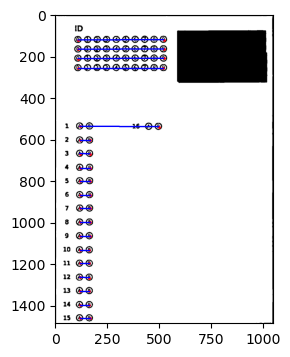

In [219]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
ax.imshow(Original, cmap=plt.cm.gray)

Bubbles = [(cx,cy,rad) for cx,cy,rad in zip(cx,cy,rad)]
Bubbles_To_Search = Bubbles.copy() # Array containing all the unsorted bubbles.
Result = [] # Array that contains our sorted rows.
Row_Number = 0
while len(Bubbles_To_Search)>0: # While the number of unsorted bubbles is not zero.
    
    # (1) Get the top left and top right of the unsorted bubbles.
    Top_Left=sorted(Bubbles_To_Search, key=lambda bubble: (bubble[0] + bubble[1]))[0] #  Represents the start of our row. Point with the smallest x and y or min(x+y).
    Top_Right=sorted(Bubbles_To_Search, key=lambda bubble: (bubble[0] - 10*bubble[1]))[-1] # Represents the end of our row. Point with the largest x and smallest y or max(x-y).
    # y is a given weight of 10 to prioritize the highest but perhaps not rightmost bubble over the rightmost but perhaps not highest bubble.
    
    # (2)  Plot the top left and top right bubbles [For demonstration purposes, removeable]
    ax.plot(Top_Left[0], Top_Left[1], '.r', markersize=2)
    ax.plot(Top_Right[0], Top_Right[1], '.r', markersize=2)
    
    # (3) Draw a line between the top left and top right bubbles, this represent our row.
    y_line,x_line = line(Top_Left[1], Top_Left[0], Top_Right[1], Top_Right[0])
    
    # (4) Plot the line [For demonstration purposes]
    ax.plot(x_line, y_line, '-b', linewidth=1)
    
    # (5) Now, measures the vertical distance of every bubble from our line, if it is withing an acceptable margin.
    # it is categorized as part of our row. 
     
    Bubbles_Within_Row = []  # This array stores bubbles categorized as part of our row. Resets every loop.
    Bubbles_Not_Within_Row = [] # This array stores every other bubble. Resets every loop.
    
     
    for bubble in Bubbles_To_Search:
        
        Acceptable_Distance = bubble[2]  # radius of the bubble represents our acceptable distance margin.
    
        distance_from_line= bubble[1]-np.mean(y_line) # vertical distance from the line.
        
        if distance_from_line < Acceptable_Distance: # If the distance from the line is within margin.
            Bubbles_Within_Row.append(bubble) # Consider the bubbles part of the row
        else:
            Bubbles_Not_Within_Row.append(bubble) # Else, bubble is not part of our row
    
    # (6) Now that we know which bubbless are in our row and as such all have the same y, we now just sort them by their x value.
    Sorted_Row=(sorted(Bubbles_Within_Row, key=lambda h: h[0])) 
    Result.append(Sorted_Row) # The sorted row is added to our result array.
    
    # (7) Unsorted bubble list is updated. 
    Bubbles_To_Search = Bubbles_Not_Within_Row


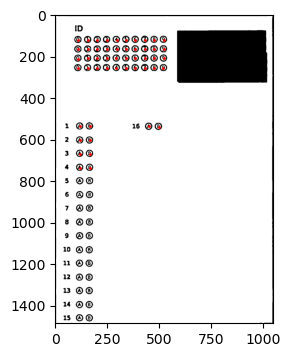

In [220]:
# Plot the first i rows. 
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
ax.imshow(Original, cmap=plt.cm.gray)
# Plot the first i points
i= 8
for row in Result[:i]:
    for point in row:
      ax.plot(point[0], point[1], '.r', markersize=2)
      
      

Number of ID Rows:  4
Number of Question Rows:  15


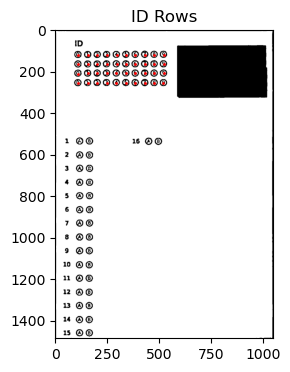

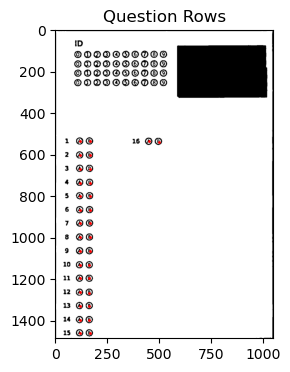

In [221]:
# Segmentation Logic
# 1) If the vertical distance between one row and the next is large, then this is the end of our ID.

#=========================================================================================================
# Segment the rows into IDs and Choices.
#=========================================================================================================
Id_Rows = []
Question_Rows=[]

for row in range(len(Result)):
    Row1_Y = [bubble[1] for bubble in Result[row]]
    Row2_Y = [bubble[1] for bubble in Result[row+1]]
    Row_Radii = [bubble[2] for bubble in Result[row]]
    Threshold = 4*np.mean(Row_Radii)
    
    Vertical_Distance_Between_Rows = np.mean(Row2_Y)-np.mean(Row1_Y)
    if Vertical_Distance_Between_Rows > Threshold:
        Id_Rows = Result[:row+1]
        Question_Rows=Result[row+1:]
        break


print("Number of ID Rows: ",len(Id_Rows))
print("Number of Question Rows: ",len(Question_Rows))

#plot the id rows
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
ax.imshow(Original, cmap=plt.cm.gray)
ax.set_title("ID Rows")
for row in Id_Rows:
    for point in row:
      ax.plot(point[0], point[1], '.r', markersize=2)
      
#plot the question rows
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
ax.imshow(Original, cmap=plt.cm.gray)
ax.set_title("Question Rows")
for row in Question_Rows:
    for point in row:
      ax.plot(point[0], point[1], '.r', markersize=2)


In [222]:
# Get the number of choices for each question.
# The number of choices is the number of bubbles until a next large horizontal distance.
# The number of choices is the same for all questions so we just need to find it for one question.

# Get the first question row.
Question_Row = Question_Rows[0]
# Get the horizontal distance between each bubble in the first question row.
Horizontal_Distance_Between_Bubbles = [Question_Row[i+1][0]-Question_Row[i][0] for i in range(len(Question_Row)-1)]
# Get the mean horizontal distance between bubbles.
Threshold = 2*np.mean(Horizontal_Distance_Between_Bubbles)
# Get the number of choices.
New_Columns = np.where(Horizontal_Distance_Between_Bubbles > Threshold)[0]

if len(New_Columns) == 0:
    Num_Of_Choices = len(Question_Row)
else:
    Num_Of_Choices= New_Columns[0]+1
    
print("Number of Choices Per Question: ", Num_Of_Choices)

Number of Choices Per Question:  2


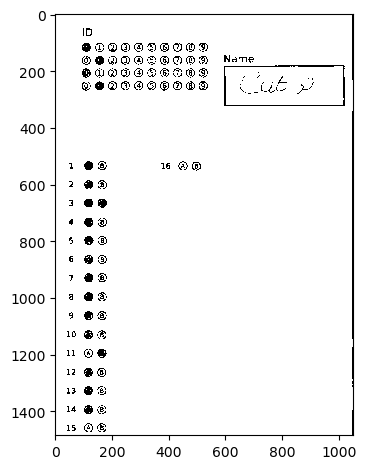

In [223]:
# Process the image to get the ID and Answers.
Unproccessed_Img = io.imread("IMG_2045_Warped.jpg")
# Unproccessed_Img = io.imread("123b_Warped.jpg")
Processed_Image = pcf.Apply_Preprocessing(Unproccessed_Img,mode='Enhance',param=1, offset=12,method='mean')
io.imshow(Processed_Image)

ID:  0101


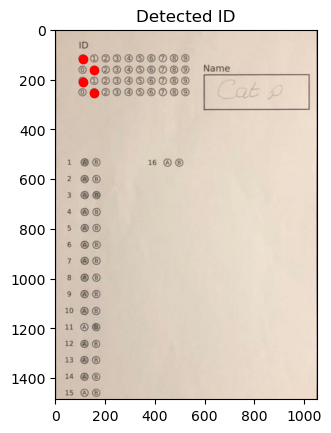

In [224]:
# Get the ID.
Id: str = ""

fig,ax=plt.subplots()
ax.imshow(Unproccessed_Img, cmap=plt.cm.gray)
ax.set_title("Detected ID")

for Row_Number, row in enumerate(Id_Rows):
    Num=0
    Threshold=0
    for bubble in row:
        x = bubble[0]
        y = bubble[1]
        r = bubble[2] 
        # Get the bubble.
        rr,cc=disk((y,x),r)
        Bubble= Processed_Image[rr,cc]
        # Get the mean of the bubble.
        Threshold+= np.mean(Bubble)
        # If the mean is below a threshold, then the bubble is filled.
  
    Threshold /=len(row)
  
    for bubble in row:
        x = bubble[0]
        y = bubble[1]
        r = bubble[2] 
        # Get the bubble.
        rr,cc=disk((y,x),r)
        Bubble= Processed_Image[rr,cc]
        # Get the mean of the bubble.
        Mean= np.mean(Bubble)
        # If the mean is below threshold, then the bubble is filled.
  
        if Mean < 0.75*Threshold:
                Id += str(Num) 
                ax.plot(x,y,"or")

        Num+=1
        
    if len(Id)> Row_Number+1:
        print("Error: Multiple filled bubbles.")
        Id="Error"
        break
    
    if len(Id)< Row_Number+1:
        print("Error: Some bubbles are not filled properly.")
        Id="Error"
        break
    
    
            
            
print("ID: ", Id)

Id: 0101
1) A
2) A
3) A
4) A
5) A
6) A
7) A
8) A
9) A
10) A
11) B
12) A
13) A
14) A
15) Invalid
16) Invalid


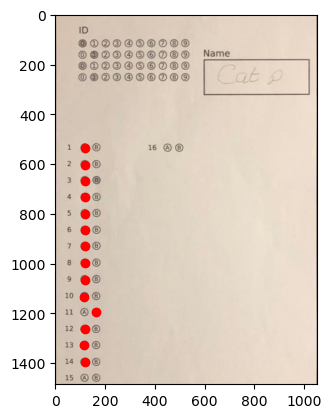

In [225]:
# Get the first question row.
Question_Row = Question_Rows[0]
# Get the horizontal distance between each bubble in the first question row.
Horizontal_Distance_Between_Bubbles = [Question_Row[i+1][0]-Question_Row[i][0] for i in range(len(Question_Row)-1)]
# Get thereshold based on mean horizontal distance between bubbles.
Threshold = 2*np.mean(Horizontal_Distance_Between_Bubbles)
fig,ax = plt.subplots()
ax.imshow(Unproccessed_Img, cmap=plt.cm.gray)
Answers=np.zeros([500],dtype=str)
Num_Of_Questions = 0

for Question_Number , row in enumerate(Question_Rows):
    Num_Of_Columns = int(len(row) / Num_Of_Choices)
    
    
    for col in range (Num_Of_Columns):
        Choice = 'A'
        Threshold = 0
        Counter=0
        for bubble in row[col*Num_Of_Choices: Num_Of_Choices*(1+col)]: 
            x = bubble[0]
            y = bubble[1]
            r = bubble[2] 
            # Get the bubble.
            rr,cc=disk((y,x),r,shape=Processed_Image.shape)
            Bubble= Processed_Image[rr,cc]
            # Get the mean of the bubble.
            Threshold+= np.mean(Bubble)
        
        Threshold/= Num_Of_Choices
            
            
                
        for bubble in row[col*Num_Of_Choices: Num_Of_Choices*(1+col)]: 
            x = bubble[0]
            y = bubble[1]
            r = bubble[2] 
            # Get the bubble.
            rr,cc=disk((y,x),r,shape=Processed_Image.shape)
            Bubble= Processed_Image[rr,cc]
            # Get the mean of the bubble.
            Mean = np.mean(Bubble)
            # If the mean is below a threshold, then the bubble is filled.
            if Mean < 0.9*Threshold:
                Counter+=1
                # Invalid choices such as no choice or multiple shaded bubbles will result in an empty string
                if Counter>1:
                    Answers[Question_Number + col*len(Question_Rows)]= ""
                    ax.plot(x,y,"xb")
                    continue
                Answers[Question_Number + col*len(Question_Rows)]= Choice
                ax.plot(x,y,"or")
                    
            
            Choice=chr(ord(Choice)+1)
        Num_Of_Questions+=1
            
Answers = Answers[:Num_Of_Questions]
print(f"Id: {Id}")
# The answers array acts like a look up table
for Question in range(Num_Of_Questions):
    if Answers[Question]!= "":
        print(f"{Question+1}) {Answers[Question]}")
    else:
        print (f"{Question+1}) Invalid")

In [230]:
with open("ModelAnswer.txt", "rt") as f:
    Model_Answers = f.read().splitlines()

from tempfile import NamedTemporaryFile
import shutil

tempfile = NamedTemporaryFile(mode='w', delete=False)
fields= ["ID"]+[f"Q{i+1}" for i in range(Num_Of_Questions)]+["Score"]
Grades = (Answers == Model_Answers[:Num_Of_Questions]).astype(int)

# Attempt to open the file and add the new grades.
try:
    with open("BubbleAnswers.csv", "rt") as csvfile, tempfile:
        reader = csv.DictReader(csvfile, fieldnames=fields)
        writer = csv.DictWriter(tempfile, fieldnames=fields)
        for row in reader:
            if row["ID"] == "ID_"+Id:
                print("Error: ID already exists.")
                break
            writer.writerow(row)
        row["ID"] = "ID_"+Id # ID_ is added to the beginning of the string to avoid leading zeros being removed.
        for i in range(Num_Of_Questions):
            row[f"Q{i+1}"] = Grades[i]
        row["Score"] = np.sum(Grades)
        writer.writerow(row)
    shutil.move(tempfile.name, "BubbleAnswers.csv")
    
# If the file does not exist, create the file and add the new grades.
# If its a different exam with a different amount of questions, create a new file.
except (FileNotFoundError, ValueError):
    with open("BubbleAnswers.csv", "wt+") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["ID"]+[f"Q{i+1}" for i in range(Num_Of_Questions)]+["Score"])
        writer.writerow([f"ID_{Id}"]+list(Grades)+[np.sum(Grades)])
except PermissionError:
    print("Error: File is open. Close it and try again.")
    
    


Error: ID already exists.
